<img style ="float:right" src = "https://d1vwxdpzbgdqj.cloudfront.net/s3-public-images/learning-partners/greatlearning-brand.svg" width=15%>

# Project- Recommendation Systems : Movie Recommendations

## Marks : 40
---------------
## Context
---------------

Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system. 

-----------------
## Objective
-----------------

Build a recommendation system to recommend movies to users based on the ratings given to different movies by the user: 

-----------------
## Dataset
-----------------

The **dataset** dataset contains the following attributes: 
- userId
- movieId
- rating

## Importing Libraries

### One of the first steps in any data science task is importing the necessary tools you will use.


In [1]:
#uncomment if you not installed the scikit surprise library
!pip install scikit-surprise

#importing libaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from surprise import Reader
from surprise import Dataset
from surprise import  SVD, NormalPredictor, KNNBasic
from surprise.model_selection import cross_validate
from surprise import accuracy
from IPython.display import display
from collections import defaultdict
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

## Reading the Data

In [2]:
col_names = ['userId', 'movieId', 'rating', 'timestamp']
data = pd.read_table('u.data', names=col_names)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100000 non-null  int64
 1   movieId    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


**Observations:**
- There are **1,00,000 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**


In [3]:
data = data.drop('timestamp', axis=1)

### Question 1
#### 1.1 Print top 5 rows of the dataset and describe the dataset.  ( 1 Mark)
#### 1.2 Describe the distribution of ratings. ( 1 Mark )

In [4]:
#printing the top 5 rows of the dataset Hint use .head()
data.head()

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


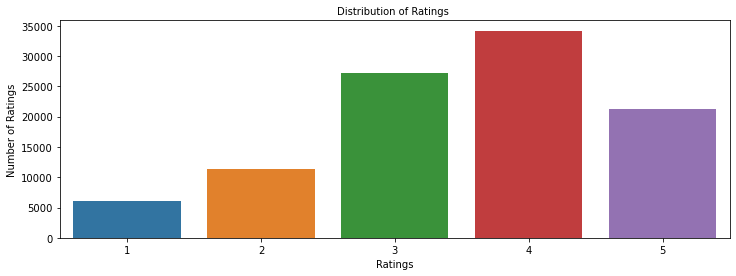

In [5]:
#describe the distribution of ratings

plt.figure(figsize = (12, 4))
sns.countplot(x = "rating", data = data)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [6]:
data.rating.value_counts(normalize=True)

4    0.34174
3    0.27145
5    0.21201
2    0.11370
1    0.06110
Name: rating, dtype: float64

**Write your answer here:**
Dataset has 100000  rows and 3 columns.(Originaly 4 columns and we drop one of them.) There are no Nulls in the dataset. The ratings are ranging from 1 to 5.

Data is somehow skewed towards Rating '4'. Rating '3' is second highest in count.

We can see many people are giving rating between 3 to 5. It shows people are tend to giving a rating for a movie which they like.

#### Q 1.3. What is the total number of unique users and unique movies? ( 1 Mark)

In [7]:
#number of unique users

data['userId'].nunique()

943

In [8]:
#number of unique movies 

data['movieId'].nunique()

1682

**Write your answer here:**
There are 934 user and 
there are 1682 movies(Items) in the dataset.
There is a possibility of the product of 934 * 1682= 1,586,126 ratings in the dataset. since we have 100000 rating in our dataset it means that many users did not rate every movies. So, we can build a recommendation system to recommend movies to users based on their interests.


In [9]:
data.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      1             1
       2             1
       3             1
       4             1
       5             1
...                ...
943    1067          1
       1074          1
       1188          1
       1228          1
       1330          1

[100000 rows x 1 columns]

In [10]:
data.groupby(['userId', 'movieId']).count()['rating'].sum()

100000

- The **sum is equal to the total number of observations** which implies that **there is only interaction between a pair of movies and a user**.

#### Q 1.4. Which one is the most interacted movie in the dataset? ( 1 Mark)

In [11]:
data['movieId'].value_counts()

50      583
258     509
100     508
181     507
294     485
       ... 
1543      1
1583      1
1647      1
711       1
1663      1
Name: movieId, Length: 1682, dtype: int64

**Write your answer here:**
The movie with Id number:50 has been interacted by most users which is 583 times.
But still, there is a possibility of 943-583 = 360 more interactions as we have 943 unique users in our datasets. For those remaining users, we can build a recommendation system to predict who is most likely to interact with this movie.
Also, out of these 583 interactions, we need to consider the distribution of ratings as well to check whether this movie is the most liked or most disliked one.

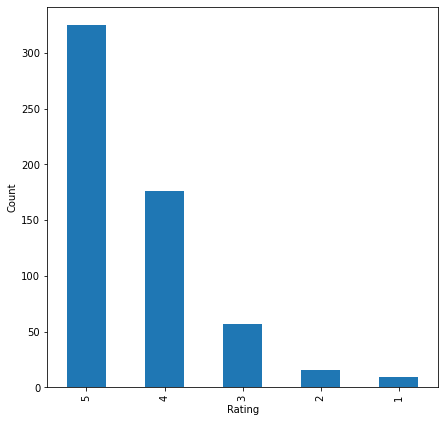

In [12]:
#Plotting distributions of ratings for 583 interactions with movieid 50 

plt.figure(figsize=(7,7))

data[data['movieId'] == 50]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Write your answer here:**
We can see that this movie has been liked by the majority of users, as the count of ratings 5 and 4 is higher than the count of other ratings.
There can be movies with very high interactions but the count of ratings 1 and 2 may be much higher than 4 or 5 which would imply that the movie is disliked by the majority of users.

#### Analysis of Ratings by users

##### Q 1.5. Which user interacted the most with any movie in the dataset? (1 Mark)

In [13]:
data['userId'].value_counts()

405    737
655    685
13     636
450    540
276    518
      ... 
571     20
364     20
812     20
572     20
895     20
Name: userId, Length: 943, dtype: int64

**Write your answer here:**
The user with userId: 405 has interacted with the most number of movies which is 737 times.
But still, there is a possibility of 1682-737 = 948 more interactions as we have 1682 unique movies in our dataset. For those 948 remaining movies, we can build a recommendation system to predict which movies are most likely to be liked by this user.

#### Q 1.6. What is the distribution of the user-movie interactions in this dataset? (1 Mark)

In [14]:
#Finding user-movie interactions distribution

count_interactions = data.groupby('userId').count()['movieId']
count_interactions

userId
1      272
2       62
3       54
4       24
5      175
      ... 
939     49
940    107
941     22
942     79
943    168
Name: movieId, Length: 943, dtype: int64

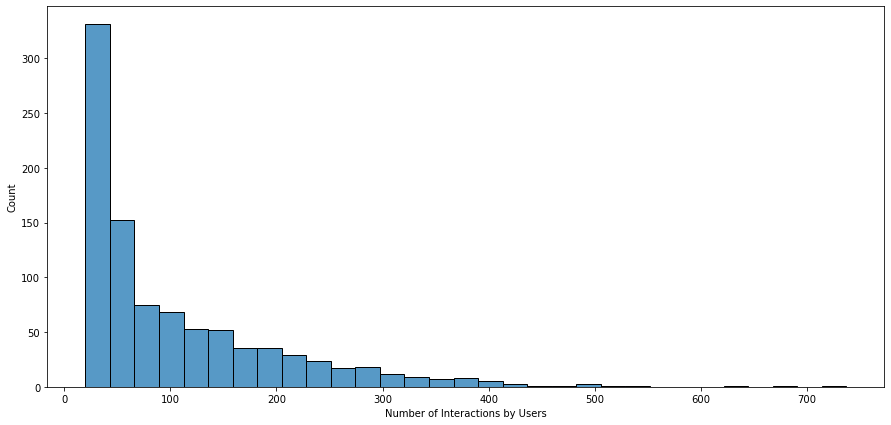

In [15]:
#Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Write your answer here:**

- It is a right skewed and abviously there are very few movies has been rated by users.

### As now we have explored the data, let's start building Recommendation systems 

### Question 2: Create Rank Based Recommendation System ( Marks 6 )

### Model 1: Rank Based Recommendation System

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [16]:
#Calculating average ratings
average_rating = data.groupby('movieId').mean()['rating']

#Calculating the count of ratings
count_rating = data.groupby('movieId').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [17]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [18]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

##### Recommending top 5 movies with 50 minimum interactions based on popularity

In [19]:
list(top_n_movies(final_rating, 5, 50))

[408, 318, 169, 483, 114]

##### Recommending top 5 movies with 100 minimum interactions based on popularity

In [20]:
list(top_n_movies(final_rating, 5, 100))

[408, 318, 169, 483, 64]

##### Recommending top 5 movies with 200 minimum interactions based on popularity

In [21]:
list(top_n_movies(final_rating, 5, 200))

[318, 483, 64, 603, 12]

### Now that we have seen how to apply the Rank-Based Recommendation System Let's build collaborative filtering and matrix factorization using SVD.

## Cross Validation


We will be using cross validation a lot in this code in the training and evaluation of our models. This strategy builds upon the idea of a train-test split, which you should already be familiar with.

Instead of doing 1 data split, though, we will do several of them. Each split of the data is called a fold. We let k denote the number of folds we use. k=5 is a common number to use.

This image provides a visual explanation of how cross validation works.

<img src ="https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg"></img>

### We will use "cross_validate" from surprise package to run the models as listed and check their respective RMSEs

**In surprise library, we have to change our dataset to surprise dataset. For which we use Reader function from surprise package**

In [22]:
#coverting data in to surprise dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

## Model 2: Random Baseline Model 

We want to first get a baseline value for our model. What better way to do that than with a random algorithm! Essentially, this first algorithm is not personalized to the desires of any users - we just assign them movie ratings based on the initial distribution of the data.

See the Model 2: Random section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

In [23]:
#Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

model_random = NormalPredictor()

In [24]:
model_using_normal_predictor = cross_validate(model_random, data,measures=['RMSE'],cv=5, verbose=False)

In [25]:
print('Average RMSE for Test Set using {} is '.format(model_random.__class__.__name__),model_using_normal_predictor['test_rmse'].mean())

Average RMSE for Test Set using NormalPredictor is  1.5245018388929903


## Model 3: User-Based Collaborative Filtering

Surely, we can do much better than guessing the movie ratings randomly! Our next model will use the user-user defined notion of similarity to implement collaborative filtering.

See the Model 3: User-Based Collaborative Filtering section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

**We will use KNNBasic and add parameter 'cosine'. Like we have other similarity measures like Euclidean distance, in recommendation systems we use cosine similarity.** 

In [26]:
#defining KNNBasic model
model_user_based = KNNBasic(sim_options ={'name':'cosine','user_base':True},verbose=False)

model_using_KNNbasic_cos_user = cross_validate(model_user_based,data,measures=['RMSE'],cv=5, verbose=False)

In [27]:
print('Average RMSE for Test Set using {} is '.format(model_user_based.__class__.__name__),model_using_KNNbasic_cos_user['test_rmse'].mean())

Average RMSE for Test Set using KNNBasic is  1.0168642766169236


## Model 4 : Item-Based Collaborative Filtering

Our next model will use the item-item defined notion of similarity to once again implement collaborative filtering.

See the Model 4: Item-Based Collaborative Filtering section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

In [28]:
#defining KNNBasic model
model_item_based = KNNBasic(sim_options ={'name':'cosine','user_base':False},verbose=False)

model_using_KNNbasic_cos_item = cross_validate(model_user_based,data,measures=['RMSE'],cv=5, verbose=False)

In [29]:
print('Average RMSE for Test Set using {} is '.format(model_item_based.__class__.__name__),model_using_KNNbasic_cos_item['test_rmse'].mean())

Average RMSE for Test Set using KNNBasic is  1.0162689318358213


### Question 3 ( 8 Marks)
#### 3.1 Compare the results from the user-user and item-item models.
#### 3.2 How do they compare to each other? How do they compare to our original "random" model?
#### 3.3 Can you provide any intuition as to why the results came out the way they did?

**Write your answer here:**

User-based and Item-based Collaborative Models have almost same RMSE values while the "random" model's RMSE is higher than both of them. Collaborative Filtering Models seems to have a better performance than random model.

The Collaborative Models use the user-item-ratings data to find all similarities and make predictions, but random model just predicting a random rating based on the distribution of the data. That's why the Collaborative Models performed better.

## Model 5: Matrix Factorization

Our final model for this case study will use the matrix factorization approach with the SVD algorithm to try to predict user’s movie ratings. Here, we try to determine some underlying mathematical structure in the user rating matrix, which can help us predict missing ratings in the future.

See the Model 5: Matrix Factorization section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

In [30]:
#matrix factorisation using svd
model_svd = SVD()
model_using_svd = cross_validate(model_svd,data,measures=['RMSE'],cv=5, verbose=False)

In [31]:
print('Average RMSE for Test Set using {} is '.format(model_svd.__class__.__name__),model_using_svd['test_rmse'].mean())

Average RMSE for Test Set using SVD is  0.9365115959005257


### Question 4 (6 Marks)
#### 4.1 The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE again.
#### 4.2 Does it improve? Can you offer any reasoning as to why that might be?

**Answer:**

Collaborative Filtering starts searcheing for neighbors based on similarity of movies preferences and recommend the movie that those neighbors liked while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

RMSE for Matrix Factorization (0.9368...) is better than the Collaborative Filtering Models(1.0170...).

Matrix Factorization has lower RMSE due to the reason that it assumes that both movie and users are present in some low dimensional space describing their properties and recommend a movie based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

## Precision and Recall @ k

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

### Question 5 (8 Marks)
#### 5.1 Compute the precision and recall, for each of the 4 models, at k = 5 and 10. This is 2 x 2 x 4 = 16 numerical values. Do you note anything interesting about these values? 
#### 5.2 Anything different from the RMSE values you computed above?

In [32]:
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [33]:
#A basic cross-validation iterator.
kf = KFold(n_splits=5)

In [34]:
# Make list of k values
K = [5, 10]

# Make list of models
models = [model_random, model_user_based, model_item_based, model_svd]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=NormalPredictor
-----> Precision:  0.567
-----> Recall:  0.321
> k=5, model=KNNBasic
-----> Precision:  0.735
-----> Recall:  0.439
> k=5, model=KNNBasic
-----> Precision:  0.737
-----> Recall:  0.44
> k=5, model=SVD
-----> Precision:  0.724
-----> Recall:  0.41
> k=10, model=NormalPredictor
-----> Precision:  0.568
-----> Recall:  0.413
> k=10, model=KNNBasic
-----> Precision:  0.706
-----> Recall:  0.577
> k=10, model=KNNBasic
-----> Precision:  0.704
-----> Recall:  0.577
> k=10, model=SVD
-----> Precision:  0.702
-----> Recall:  0.541


**Write your answer here:**
<img src="https://i.ibb.co/rszmmx6/download-24.png" ></img>



*Precision quantifies the number of positive class predictions that actually belong to the positive class.

*Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.

These values are lowest for Random. Collaborative Filtering performed well in both the k values with Precision value ~74% and with k=5, ~73%.

SVD has better (lower) RMSE but Collaborative Filtering using Item-Item or User-User have better Precision & Recall.

RMSE values are used for Continuous d-type while Precision-Recall are calculated for categorical d-type using Confusion matrix. Thus cannot be compared directly.


## Top-n Predictions

Finally, we want to actually see what ratings the model predicts for our users. We can vary the amount of top movies we see per user by varying the value of n.

See the Top-n Predictions section of your notebook and follow the instructions to compute rating predictions for some users.

 <a href=https://surprise.readthedocs.io/en/stable/FAQ.html>documentation surprise</a>

In [35]:

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [36]:

trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [37]:

#Making a list of all the columns 

models = [model_random, model_user_based, model_item_based, model_svd]
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print the first one
    user = list(top_n.keys())[0]
    print(f'model: {model.__class__.__name__}, {user}: {np.round(top_n[user],2)}')

model: NormalPredictor, 196: [[  95    5]
 [1137    5]
 [ 181    5]
 [ 143    5]
 [  20    5]]
model: KNNBasic, 196: [[1189    5]
 [1500    5]
 [ 814    5]
 [1536    5]
 [1293    5]]
model: KNNBasic, 196: [[1189    5]
 [1500    5]
 [ 814    5]
 [1536    5]
 [1293    5]]
model: SVD, 196: [[197.     4.64]
 [603.     4.49]
 [272.     4.45]
 [134.     4.45]
 [483.     4.43]]


In [38]:
columns_1 = ['movie id ','movie title' , 'release date' , 'video release date ','IMDb URL ', 'unknown' , 'Action ', 'Adventure' ,'Animation', "Childrens" , 'Comedy' ,
             'Crime','Documentary','Drama', 'Fantasy' ,'Film-Noir', 'Horror' ,'Musical', 'Mystery' ,'Romance' , 'Sci-Fi' ,'Thriller' ,'War' ,'Western ']

In [39]:
item_list = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item',sep="|", encoding="iso-8859-1",header=None,names=columns_1)

In [40]:
columns_2 = ['user id','age', 'gender' , 'occupation' , 'zip code']

In [41]:
user_list = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.user',sep="|", encoding="iso-8859-1",header=None,names=columns_2)

In [42]:
x=196
print('Movies Recommended for user {} who is a {} by occupation are: '.format(x,user_list[user_list['user id'] ==x]['occupation'].values[0]))
for i in range(0,len(top_n[x])):
    print(item_list[item_list['movie id ']==top_n[196][i][0]]['movie title'].values[0],' ',np.round(top_n[196][i][1],2))

Movies Recommended for user 196 who is a writer by occupation are: 
Graduate, The (1967)   4.64
Rear Window (1954)   4.49
Good Will Hunting (1997)   4.45
Citizen Kane (1941)   4.45
Casablanca (1942)   4.43


### Question 6 ( 6 Marks)
#### 6.1 Do the top n predictions that you received make sense? (Try searching of the movie on internet if you have not watched them)
#### 6.2 What is the rating value (1-5) of these predictions?
#### 6.3 How could you use these predictions in the real-world if you were trying to build a generic content recommender system for a company?

**Write your Answer here:**

As we expected, we have got the predictions (n=5) for each model. We printed the predictions for One user for each model. Collaborative models  (User-based & Item-based) have given exactly same recommendations.

The rating values for Random, User-based, Item-based is fixed at 5, and Matrix Factorization using SVD is from 4.47 to 4.66 . 

Here our user is a writer, and it's acceptable that he/she is interested in all genres, otherwise the recommendations would look wierd.

*Recommender systems are used by streaming services portals to recommend movies to their subscribers. The movie can be recommended based on the top top rated one, based on the profile's information of the user, or based on an analysis of the watching history of the user as a prediction for future choices.